In [2]:
import pandas as pd
import numpy as np
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## datos
sheets = ["SE", "CE", "SO", "NE2", "SE2", "SE3", "NE", "NO", "NO2", "NTE", "NTE2", "SO2", "SUR"]
dfs = pd.read_excel("datos_hist_2020_2025.xlsx", sheet_name=sheets)

## Características del Dataset Crudo y Parseo de Fechas a index

In [6]:
from pandas.tseries.frequencies import to_offset

def build_full_grid(
    df,
    dt_col="datetime",
    freq="H",
    date_format=None,   # si conoces el formato exacto ponlo; si no, lo infiere
    dayfirst=False,
    align=False         # si True: start=floor(freq), end=ceil(freq). Por defecto NO alinea.
):
    """
    Crea una malla completa con frecuencia `freq` entre el primer y último timestamp.
    NO agrega filas de más: usa exactamente min(df) y max(df) como límites, a menos que align=True.

    Devuelve:
      df_full: df reindexado a la malla
      report:  dict con info útil (filas originales, esperadas, duplicados, etc.)
    """
    if dt_col not in df.columns:
        # Toma la primera columna si no se especifica
        first_col = df.columns[0]
        dt_col = first_col

    # Parse seguro
    s = df[dt_col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
    if date_format:
        dt = pd.to_datetime(s, format=date_format, errors="coerce")
    else:
        dt = pd.to_datetime(s, errors="coerce", dayfirst=dayfirst)

    if dt.isna().all():
        raise ValueError("No se pudo parsear la columna de fecha-hora.")

    # Limpieza básica
    out = df.copy()
    out.insert(0, "_dt_", dt)
    out = out.dropna(subset=["_dt_"]).sort_values("_dt_")

    # Quitar duplicados exactos de timestamp (conserva el primero)
    dup_mask = out["_dt_"].duplicated(keep="first")
    dup_count = int(dup_mask.sum())
    out = out[~dup_mask].copy()

    # Determinar límites
    start_raw = out["_dt_"].min()
    end_raw   = out["_dt_"].max()

    if align:
        off = to_offset(freq)
        start = (start_raw.floor(freq) if hasattr(start_raw, "floor") else start_raw)
        end   = (end_raw.ceil(freq)  if hasattr(end_raw,  "ceil")  else end_raw)
    else:
        # Usar exactamente los límites observados (¡no agrega “una hora extra” por redondeo!)
        start, end = start_raw, end_raw

    # Construir malla
    full_idx = pd.date_range(start=start, end=end, freq=freq)
    original_index = pd.Index(out["_dt_"].values)

    # Reindex
    out = out.set_index("_dt_").reindex(full_idx)
    out.index.name = dt_col

    # Flags útiles
    out["was_missing_timestamp"] = ~out.index.isin(original_index)
    value_cols = [c for c in out.columns if c not in ("was_missing_timestamp",)]
    present_mask = out.index.isin(original_index)
    has_na_present = out.loc[present_mask, value_cols].isna().any(axis=1) if value_cols else pd.Series(False, index=out.index[present_mask])
    out["has_missing_values"] = False
    out.loc[present_mask, "has_missing_values"] = has_na_present.values

    # Reporte
    report = {
        "rows_original": int(len(original_index)),
        "rows_expected_full": int(len(full_idx)),
        "duplicate_timestamps_dropped": dup_count,
        "missing_timestamps_count": int(out["was_missing_timestamp"].sum()),
        "first_timestamp_used": str(start),
        "last_timestamp_used":  str(end),
        "aligned": bool(align),
        "freq": str(freq),
    }
    return out, report


In [8]:
def display_grid_report(basics_dict, title="📊 REPORTE DE GRILLAS TEMPORALES"):
    """
    Muestra los resultados de build_full_grid de manera atractiva y organizada
    """
    print("="*80)
    print(f"{title:^80}")
    print("="*80)
    
    # Resumen general
    print(f"\n🌍 {'RESUMEN GENERAL':^66}")
    print("─"*68)
    
    total_zones = len(basics_dict)
    total_original = sum(report['rows_original'] for report in basics_dict.values())
    total_expected = sum(report['rows_expected_full'] for report in basics_dict.values())
    total_duplicates = sum(report['duplicate_timestamps_dropped'] for report in basics_dict.values())
    total_missing = sum(report['missing_timestamps_count'] for report in basics_dict.values())
    
    print(f"📍 Zonas analizadas: {total_zones}")
    print(f"📋 Filas originales totales: {total_original:,}")
    print(f"📈 Filas esperadas totales: {total_expected:,}")
    print(f"🔄 Duplicados eliminados: {total_duplicates:,}")
    print(f"❌ Timestamps faltantes: {total_missing:,}")
    print(f"📊 Completitud promedio: {((total_original/total_expected)*100):.1f}%")
    
    # Detalles por zona
    print(f"\n📋 {'DETALLES POR ZONA':^66}")
    print("─"*68)
    
    # Header de tabla
    print(f"{'Zona':<6} {'Original':<10} {'Esperado':<10} {'Duplicados':<10} {'Faltantes':<10} {'Completitud':<12}")
    print("─"*68)
    
    # Datos por zona
    for zone, report in basics_dict.items():
        completeness = (report['rows_original'] / report['rows_expected_full']) * 100
        print(f"{zone:<6} {report['rows_original']:<10,} {report['rows_expected_full']:<10,} "
              f"{report['duplicate_timestamps_dropped']:<10,} {report['missing_timestamps_count']:<10,} "
              f"{completeness:<11.1f}%")
    
    # Rangos temporales
    print(f"\n📅 {'RANGOS TEMPORALES':^66}")
    print("─"*68)
    
    print(f"{'Zona':<6} {'Fecha Inicial':<20} {'Fecha Final':<20} {'Frecuencia':<12}")
    print("─"*68)
    
    for zone, report in basics_dict.items():
        # Formatear fechas para mejor legibilidad
        start_date = report['first_timestamp_used'][:19]  # Remover microsegundos
        end_date = report['last_timestamp_used'][:19]
        
        print(f"{zone:<6} {start_date:<20} {end_date:<20} {report['freq']:<12}")
    
    # Estadísticas adicionales
    print(f"\n📈 {'ESTADÍSTICAS ADICIONALES':^66}")
    print("─"*68)
    
    zones_with_duplicates = sum(1 for report in basics_dict.values() if report['duplicate_timestamps_dropped'] > 0)
    zones_with_missing = sum(1 for report in basics_dict.values() if report['missing_timestamps_count'] > 0)
    max_completeness_zone = max(basics_dict.items(), key=lambda x: x[1]['rows_original']/x[1]['rows_expected_full'])
    min_completeness_zone = min(basics_dict.items(), key=lambda x: x[1]['rows_original']/x[1]['rows_expected_full'])
    
    print(f"🔄 Zonas con duplicados: {zones_with_duplicates}/{total_zones}")
    print(f"❌ Zonas con datos faltantes: {zones_with_missing}/{total_zones}")
    print(f"🥇 Zona con mejor completitud: {max_completeness_zone[0]} "
          f"({(max_completeness_zone[1]['rows_original']/max_completeness_zone[1]['rows_expected_full']*100):.1f}%)")
    print(f"🥉 Zona con menor completitud: {min_completeness_zone[0]} "
          f"({(min_completeness_zone[1]['rows_original']/min_completeness_zone[1]['rows_expected_full']*100):.1f}%)")
    
    print("="*80)
    print("✅ Análisis completado exitosamente")
    print("="*80)

# Procesar datos y generar reporte
basics = dict()
for key, df in dfs.items():
    grid_df, rep_grid = build_full_grid(df)
    basics[key] = rep_grid

# Mostrar reporte atractivo
display_grid_report(basics)

C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)
C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)
C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)
C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)
C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprec

                        📊 REPORTE DE GRILLAS TEMPORALES                         

🌍                          RESUMEN GENERAL                          
────────────────────────────────────────────────────────────────────
📍 Zonas analizadas: 13
📋 Filas originales totales: 56,319
📈 Filas esperadas totales: 56,471
🔄 Duplicados eliminados: 0
❌ Timestamps faltantes: 152
📊 Completitud promedio: 99.7%

📋                         DETALLES POR ZONA                         
────────────────────────────────────────────────────────────────────
Zona   Original   Esperado   Duplicados Faltantes  Completitud 
────────────────────────────────────────────────────────────────────
SE     4,343      4,344      0          1          100.0      %
CE     4,344      4,344      0          0          100.0      %
SO     4,202      4,344      0          142        96.7       %
NE2    4,342      4,343      0          1          100.0      %
SE2    4,343      4,344      0          1          100.0      %
SE3    4,34

C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)
C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)
C:\Users\Andre\AppData\Local\Temp\ipykernel_32464\4157281207.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)


In [104]:
grid_df.dtypes

date                      object
CO                       float64
NO                       float64
NO2                      float64
NOX                      float64
O3                       float64
PM10                     float64
PM2.5                    float64
PRS                      float64
RAINF                    float64
RH                       float64
SO2                      float64
SR                       float64
TOUT                     float64
WSR                      float64
WDR                      float64
was_missing_timestamp       bool
has_missing_values          bool
dtype: object

In [105]:
rep_grid

{'rows_original': 44511,
 'rows_expected_full': 48192,
 'duplicate_timestamps_dropped': 0,
 'missing_timestamps_count': 3681,
 'first_timestamp_used': '2020-01-01 00:00:00',
 'last_timestamp_used': '2025-06-30 23:00:00',
 'aligned': False,
 'freq': 'H'}

## Identificación de Outliers

In [9]:
# CONFIGURACIÓN DE RANGOS

# Rangos del fabricante (errores de medición)
MFG_RANGES = {
    "PM10":  (0, 1000),
    "PM2.5": (0, 1000),
    "O3":    (0, 1000),
    "NO":    (0, 500),
    "NO2":   (0, 500),
    "NOx":   (0, 500),
    "SO2":   (0, 500),
    "CO":    (0, 50),
    "RH":    (0, 100),
    "WS":    (0, 180),
    "TEMP":  (-50, 50),
    "SR":    (0, 1.4),
    "BP":    (49.9, 824),
    "WD":    (0, 360),
    # RAINF: conteo * 0.01; solo validamos que no sea negativo
    "RAINF": (0, None),
}

# Rangos de operación por AÑO (outliers)
OP_RANGES = {
    2020: {"PM10":(0,800),"PM2.5":(0,205.94),"O3":(0,153),"NO":(0,500),"NO2":(0,200),
           "NOx":(0,500),"SO2":(0,200),"CO":(0,20),"RH":(0,100),"WS":(0,75),
           "TEMP":(0,41),"SR":(0,1.0),"BP":(690,750),"WD":(0,360),"RAINF":(0,30)},
    2021: {"PM10":(0,800),"PM2.5":(0,325),"O3":(0,175),"NO":(0,350),"NO2":(0,100),
           "NOx":(0,400),"SO2":(0,300),"CO":(0,10),"RH":(0,100),"WS":(0,40),
           "TEMP":(-6.5,45),"SR":(0,1.0),"BP":(690,740),"WD":(0,360),"RAINF":(0,80)},
    2022: {"PM10":(0,999),"PM2.5":(0,450),"O3":(0,160),"NO":(0,400),"NO2":(0,175),
           "NOx":(0,420),"SO2":(0,200),"CO":(0,10),"RH":(0,100),"WS":(0,35),
           "TEMP":(-5,45),"SR":(0,1.25),"BP":(700,740),"WD":(0,360),"RAINF":(0,25)},
    2023: {"PM10":(0,900),"PM2.5":(0,800),"O3":(0,175),"NO":(0,500),"NO2":(0,175),
           "NOx":(0,500),"SO2":(0,250),"CO":(0,14),"RH":(0,100),"WS":(0,40),
           "TEMP":(0,45),"SR":(0,1.0),"BP":(690,740),"WD":(0,360),"RAINF":(0,70)},
    2024: {"PM10":(0,999),"PM2.5":(0,999),"O3":(0,180),"NO":(0,400),"NO2":(0,130),
           "NOx":(0,500),"SO2":(0,150),"CO":(0,18),"RH":(0,100),"WS":(0,38),
           "TEMP":(-4,45.5),"SR":(0,1.26),"BP":(687.5,740),"WD":(0,360),"RAINF":(0,50)},
    2025: {"PM10":(0,820),"PM2.5":(0,350),"O3":(0,185),"NO":(0,350),"NO2":(0,175),
           "NOx":(0,400),"SO2":(0,405),"CO":(0,10),"RH":(0,100),"WS":(0,40),
           "TEMP":(-4.5,45),"SR":(0,1.2),"BP":(688,740),"WD":(0,360),"RAINF":(0,25)},
}

# Aliases para normalizar nombres de columnas (ajústalos si tu dataset usa otros)
ALIASES = {
    "TOUT": "TEMP",
    "WSR":  "WS",
    "PRS":  "BP",
    "NOX":  "NOx",
    "Rainf": "RAINF",
    "RainF": "RAINF",
}


In [10]:
def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [str(c).strip() for c in out.columns]
    out.rename(columns={k: v for k, v in ALIASES.items() if k in out.columns}, inplace=True)
    return out

def _to_num(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = df.copy()
    out.replace({"NULL": np.nan, "NaN": np.nan, "": np.nan}, inplace=True)
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _year_op_maps(var: str):
    """Devuelve diccionarios {year: min}, {year: max} para una variable."""
    y2min, y2max = {}, {}
    for y, d in OP_RANGES.items():
        if var in d:
            y2min[y] = d[var][0]
            y2max[y] = d[var][1]
    return y2min, y2max

def check_ranges(df: pd.DataFrame,
                 datetime_col: str = "datetime",
                 year_col: str | None = None,
                 zone_col: str | None = None):
    """
    Agrega flags por variable:
        <var>_meas_error  -> fuera de rango del fabricante
        <var>_oper_outlier -> fuera de rango de operación (según año)
    Devuelve: df_flagged, long_issues, summary (conteos por tipo/variable)
    """
    # 1) normalizar columnas básicas
    df = _norm_cols(df)

    # 2) garantizar columna datetime y year
    if datetime_col in df.columns:
        dt = pd.to_datetime(df[datetime_col], errors="coerce", dayfirst=False)
    else:
        # intenta con 'date' si existe
        if "date" in df.columns:
            dt = pd.to_datetime(df["date"], errors="coerce", dayfirst=False)
        else:
            raise ValueError(f"No encuentro columna '{datetime_col}' ni 'date'")

    df = df.copy()
    df["__datetime__"] = dt

    if year_col and year_col in df.columns:
        years = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    else:
        years = df["__datetime__"].dt.year.astype("Int64")

    df["__year__"] = years

    # 3) columnas candidatas presentes
    vars_presentes = [v for v in MFG_RANGES.keys() if v in df.columns]
    # convierte a numérico
    df = _to_num(df, vars_presentes)

    # 4) generar flags
    for var in vars_presentes:
        # --- fabricante
        vmin, vmax = MFG_RANGES[var]
        val = df[var]
        if vmax is None:
            meas_err = (val < vmin)
        else:
            meas_err = (val < vmin) | (val > vmax)
        df[f"{var}_meas_error"] = meas_err.fillna(False)

        # --- operación por año
        y2min, y2max = _year_op_maps(var)
        op_min = df["__year__"].map(y2min)
        op_max = df["__year__"].map(y2max)

        oper_out = (val < op_min) | (val > op_max)
        # si no hay rango para ese año, no marcamos
        oper_out = oper_out & op_min.notna() & op_max.notna()
        df[f"{var}_oper_outlier"] = oper_out.fillna(False)

    # 5) long dataframe con issues
    id_cols = ["__datetime__", "__year__"] + ([zone_col] if zone_col and zone_col in df.columns else [])
    long_rows = []
    for var in vars_presentes:
        for kind in ("meas_error", "oper_outlier"):
            flag_col = f"{var}_{kind}"
            mask = df[flag_col]
            if not mask.any():
                continue
            if kind == "meas_error":
                vmin, vmax = MFG_RANGES[var]
            else:
                y2min, y2max = _year_op_maps(var)
                # mapeo por fila
                vmin = df.loc[mask, "__year__"].map({y: m for y, m in y2min.items()})
                vmax = df.loc[mask, "__year__"].map({y: M for y, M in y2max.items()})

            block = pd.concat([
                df.loc[mask, id_cols],
                pd.Series(var, index=df.index[mask], name="variable"),
                pd.Series(kind, index=df.index[mask], name="issue_type"),
                df.loc[mask, var].rename("value"),
            ], axis=1)

            if isinstance(vmin, pd.Series):
                block["min_allowed"] = vmin.values
                block["max_allowed"] = vmax.values
            else:
                block["min_allowed"] = vmin
                block["max_allowed"] = vmax
            long_rows.append(block)

    issues_long = pd.concat(long_rows, ignore_index=True) if long_rows else pd.DataFrame(
        columns=id_cols + ["variable","issue_type","value","min_allowed","max_allowed"]
    )

    # 6) resumen
    if not issues_long.empty:
        summary = (issues_long
                   .groupby(["variable","issue_type"])
                   .size()
                   .reset_index(name="count")
                   .sort_values(["variable","issue_type"]))
    else:
        summary = pd.DataFrame(columns=["variable","issue_type","count"])

    # 7) limpiar columnas auxiliares; deja datetime/year legibles
    df_flagged = df.drop(columns=["__year__"]).rename(columns={"__datetime__": "datetime"})
    return df_flagged, issues_long, summary


In [11]:
results = {}
for name, df in dfs.items():
    flagged, issues, summary = check_ranges(df, datetime_col="date")
    results[name] = {
        "flagged": flagged,
        "issues": issues,
        "summary": summary
    }

# Create a summary table with counts of issues for each sheet
summary_table = pd.DataFrame([
    {
        "Sheet": name,
        "Total Issues": results[name]["issues"].shape[0]
    }
    for name in dfs.keys()
])

print("=== RESUMEN GENERAL POR ZONA ===")
print(summary_table)

# Create detailed summary by issue type for each zone
print("\n=== DETALLE DE FLAGS POR TIPO Y ZONA ===")
for zone_name in sheets:
    if zone_name in results:
        zone_summary = results[zone_name]["summary"]
        if not zone_summary.empty:
            print(f"\n--- {zone_name} ---")
            print(zone_summary.to_string(index=False))
        else:
            print(f"\n--- {zone_name} ---")
            print("No se encontraron errores o valores atípicos")

# Create a consolidated view showing all flags by type across zones
print("\n=== CONSOLIDADO: TODOS LOS FLAGS POR TIPO ===")
all_summaries = []
for zone_name, data in results.items():
    zone_summary = data["summary"].copy()
    if not zone_summary.empty:
        zone_summary["zone"] = zone_name
        all_summaries.append(zone_summary)

if all_summaries:
    consolidated = pd.concat(all_summaries, ignore_index=True)
    # Pivot table to show zones vs issue types
    pivot_table = consolidated.pivot_table(
        index='zone', 
        columns=['variable', 'issue_type'], 
        values='count', 
        fill_value=0,
        aggfunc='sum'
    )
    print(pivot_table)
    
    # Summary by issue type across all zones
    print("\n=== RESUMEN POR TIPO DE ISSUE (TODAS LAS ZONAS) ===")
    issue_type_summary = consolidated.groupby(['variable', 'issue_type'])['count'].sum().reset_index()
    print(issue_type_summary.to_string(index=False))
else:
    print("No se encontraron errores en ninguna zona")

=== RESUMEN GENERAL POR ZONA ===
   Sheet  Total Issues
0     SE             0
1     CE             4
2     SO             0
3    NE2             0
4    SE2             0
5    SE3           367
6     NE             0
7     NO             0
8    NO2             0
9    NTE             0
10  NTE2             0
11   SO2             4
12   SUR             1

=== DETALLE DE FLAGS POR TIPO Y ZONA ===

--- SE ---
No se encontraron errores o valores atípicos

--- CE ---
variable   issue_type  count
      SR   meas_error      2
      SR oper_outlier      2

--- SO ---
No se encontraron errores o valores atípicos

--- NE2 ---
No se encontraron errores o valores atípicos

--- SE2 ---
No se encontraron errores o valores atípicos

--- SE3 ---
variable   issue_type  count
      BP oper_outlier    361
      SR   meas_error      3
      SR oper_outlier      3

--- NE ---
No se encontraron errores o valores atípicos

--- NO ---
No se encontraron errores o valores atípicos

--- NO2 ---
No se encontraron 

## Funciones para las Visualizaciones

In [12]:
UNITS = {
    "PM10": "µg/m³",
    "PM2.5": "µg/m³",
    "O3": "ppb",
    "SO2": "ppb",
    "NO2": "ppb",
    "CO": "ppm",
    "NO": "ppb",
    "Nox": "ppb",
    "TOUT": "°C",
    "RH": "%",
    "SR": "W/m²",
    "RAINF": "mm",
    "PRS": "hPa",
    "WSR": "m/s",
    "WDR": "° (0–360)"
}

CANDIDATES = ["SO2","RAINF","WSR","WDR"]


In [13]:

# HISTOGRAMAS

def plot_histograms(df, cols=None, bins=30, kde=True, max_cols=4, dropna=True):
    """
    Dibuja histogramas para cada variable numérica (o para 'cols' si se pasa).
    - Trata WDR con binrange=(0,360) y sin KDE.
    - Ignora columnas inexistentes automáticamente.
    """
    if cols is None:
        # Usa todas las numéricas si no se especifica
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        # Filtra por las que existan
        cols = [c for c in cols if c in df.columns]

    if dropna:
        df = df.copy()

    n = len(cols)
    if n == 0:
        print("No hay columnas para graficar.")
        return

    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.6*nrows))
    axes = np.array(axes).reshape(-1)  # vectoriza para iterar fácil

    for i, col in enumerate(cols):
        ax = axes[i]

        data = df[col].dropna() if dropna else df[col]
        if col == "WDR":
            # Histograma circular “linealizado” 0–360
            sns.histplot(data=data, bins=36, binrange=(0, 360), ax=ax, kde=False, stat="count")
            ax.set_xlim(0, 360)
            ax.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
        else:
            sns.histplot(data=data, bins=bins, ax=ax, kde=kde, stat="count")

        unit = UNITS.get(col, "")
        ax.set_title(f"{col} {f'({unit})' if unit else ''}", fontsize=11)
        ax.set_xlabel(f"{col} {f'({unit})' if unit else ''}")
        ax.set_ylabel("Frecuencia")

    # Quita ejes vacíos si sobran casillas
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [22]:
# TIME SERIES

def plot_timeseries(df, cols=None, bins=30, kde=True, max_cols=4, dropna=False):
    """
    Grafica series de tiempo (líneas) para cada variable en 'cols' (o todas numéricas).
    - Requiere un índice datetime o una columna de fecha-hora.
    - Mantiene la misma firma que 'plot_histograms'; 'bins' y 'kde' se IGNORAN aquí.

    Lógica de timestamp:
      1) Si el índice ya es DatetimeIndex, lo usa.
      2) Si no, busca una columna de tiempo entre:
         ['timestamp','Timestamp','Fecha','fecha','Date','Datetime','datetime','FechaHora','DateTime'].
         Intenta parseo con "%m/%d/%Y %I:%M:%S %p" (ej. '1/1/2020  12:00:00 AM') y luego parseo flexible.

    dropna=False: no elimina NaN antes de graficar.
    max_cols: columnas por fila en la grilla.
    """

    # --- 1) Determinar el eje de tiempo ---
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = df.index
        df_ts = df.copy()
    else:
        ts_candidates = ["date","Timestamp","Fecha","fecha","Date","Datetime","datetime","FechaHora","DateTime"]
        ts_col = next((c for c in ts_candidates if c in df.columns), None)
        if ts_col is None:
            raise ValueError("No encuentro columna de tiempo. Renombra una a 'timestamp' o agrega su nombre a ts_candidates.")

        # Normaliza dobles espacios y parsea tipo '1/1/2020  12:00:00 AM'
        s = df[ts_col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        ts = pd.to_datetime(s, format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
        if ts.isna().all():
            # Intento flexible si el formato exacto no coincide
            ts = pd.to_datetime(s, errors="coerce")
        df_ts = df.copy()
        df_ts["__ts__"] = ts
        df_ts = df_ts.dropna(subset=["__ts__"]).set_index("__ts__")
        time_index = df_ts.index

    # --- 2) Selección de columnas ---
    if cols is None:
        cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in cols if c in df_ts.columns]

    if not cols:
        print("No hay columnas para graficar.")
        return

    # --- 3) Preparar grilla ---
    n = len(cols)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.0*ncols, 3.2*nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    units_map = globals().get("UNITS", {})  # usa UNITS si ya lo definiste; si no, vacío

    # --- 4) Graficar cada serie ---
    for i, col in enumerate(cols):
        ax = axes[i]
        # Asegura numérico y orden temporal
        ser = pd.to_numeric(df_ts[col], errors="coerce")
        s = ser.dropna()

        if s.empty:
            ax.text(0.5, 0.5, f"Sin datos válidos\nen {col}", ha="center", va="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        s = s.sort_index()

        ax.plot(s.index, s.values, lw=0.8)
        unit = units_map.get(col, "")
        title = f"{col} {f'({unit})' if unit else ''}"
        ax.set_title(title, fontsize=11)
        ax.set_ylabel(f"{col}{f' ({unit})' if unit else ''}")

        # Tratamiento especial para WDR (0–360) si quieres fijar el rango
        if col.upper() == "WDR":
            ax.set_ylim(0, 360)
            ax.set_yticks([0, 90, 180, 270, 360])

    # Apaga ejes sobrantes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.autofmt_xdate()
    plt.tight_layout()
    

# GRÁFICAS DE DATOS CRUDOS

📊 Creando histogramas apilados por zona en formato 2x2...
🔬 SO2 y RAINF utilizarán escala logarítmica para mejor visualización
📈 Mostrando todos los datos sin recorte de extremos


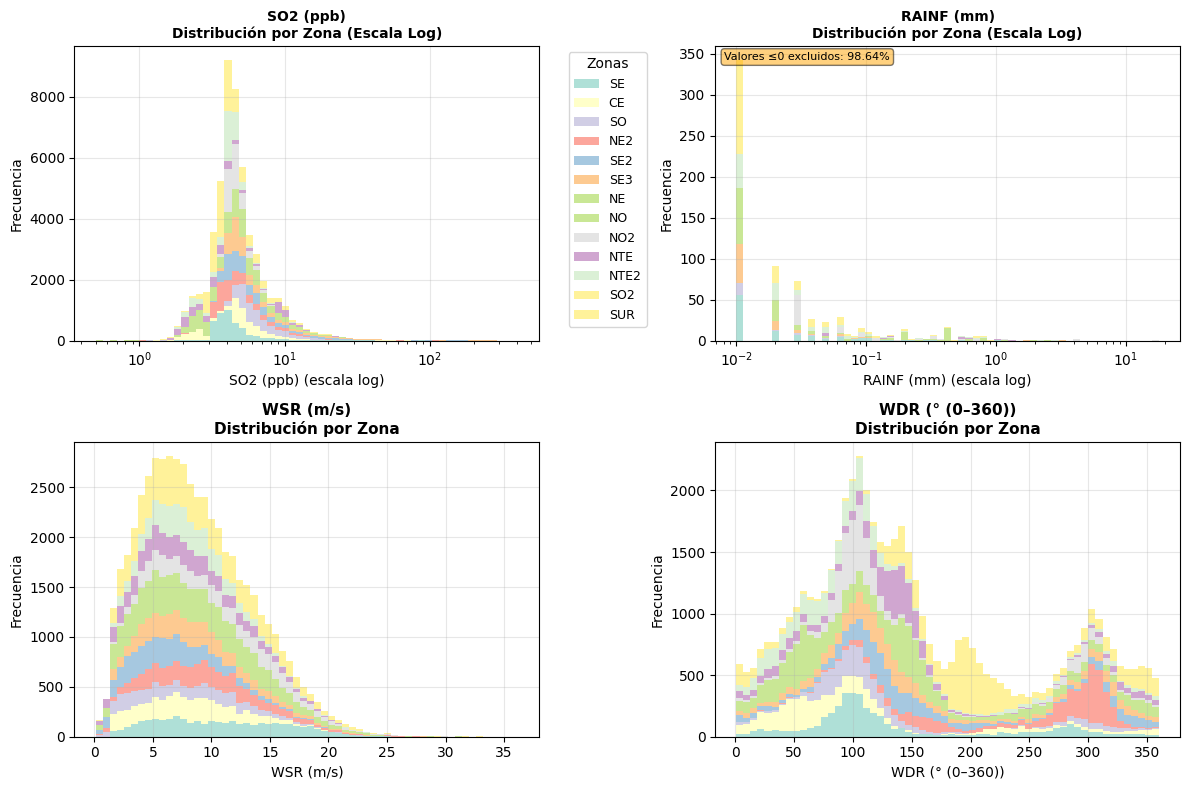


                        ESTADÍSTICAS POR ZONA Y VARIABLE                        

🔍 Variable: SO2 ppb
------------------------------------------------------------
Zona  Count  Mean   Std  Min   Max  25%  75%
  SE   4254  4.71  2.56  1.8  87.5  3.6  4.9
  CE   4263  5.18  3.49  1.3  85.8  2.9  6.0
  SO   4023  7.07  3.44  1.2  46.1  5.1  7.8
 NE2   4240  5.74  4.58  1.1 107.5  3.6  6.0
 SE2   4250  7.21  8.05  2.3 174.9  4.2  6.9
 SE3   4329  9.65 17.06  3.5 404.7  4.5  7.4
  NE   3562  5.76  4.23  0.9  84.5  4.3  6.1
  NO   4094  4.95  3.86  0.5  64.6  2.8  5.8
 NO2   4076  4.74  1.00  1.0  22.7  4.2  4.9
 NTE   3322  5.08  4.52  1.5  94.5  2.4  6.8
NTE2   4294  4.03  1.32  0.8  21.7  3.6  4.5
 SO2   4330  5.33  3.32  2.6  62.5  3.6  5.9
 SUR   4330  3.85  1.58  1.1  33.9  3.2  4.1

🔍 Variable: RAINF mm
------------------------------------------------------------
Zona  Count  Mean  Std  Min   Max  25%  75%
  SE   4255  0.00 0.02  0.0  1.03  0.0  0.0
  CE   4292  0.00 0.00  0.0  0.00  

In [25]:
# Función para crear histogramas apilados por zona
def plot_stacked_histograms_by_zone(dfs_dict, variables, bins=30, figsize=(12, 8), layout='2x2'):
    """
    Crea histogramas apilados donde cada zona tiene un color diferente
    
    Parameters:
    - dfs_dict: diccionario con {zona: dataframe}
    - variables: lista de variables a graficar
    - bins: número de bins para los histogramas
    - figsize: tamaño de la figura
    - layout: '1x4' para una fila, '2x2' para dos filas, 'auto' para automático
    """
    
    # Variables que se benefician de escala logarítmica
    LOG_SCALE_VARS = ['SO2', 'RAINF']
    
    def create_log_bins(data_list, n_bins=30):
        """
        Crea bins espaciados logarítmicamente para variables con distribución sesgada
        """
        if not data_list:
            return None
            
        # Combinar todos los datos
        all_data = np.concatenate([d for d in data_list if len(d) > 0])
        if len(all_data) == 0:
            return None
            
        # Filtrar valores positivos para escala log
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            return None
            
        # Crear bins logarítmicos
        min_val = positive_data.min()
        max_val = positive_data.max()
        
        # Evitar problemas con valores muy pequeños
        if min_val <= 0:
            min_val = positive_data[positive_data > 0].min()
            
        log_bins = np.logspace(np.log10(max(min_val, 1e-6)), np.log10(max_val), n_bins)
        return log_bins
    
    # Filtrar variables que existen en los datos
    available_vars = []
    for var in variables:
        if any(var in df.columns for df in dfs_dict.values()):
            available_vars.append(var)
    
    if not available_vars:
        print("No se encontraron variables válidas en los datos")
        return
    
    n_vars = len(available_vars)
    
    # Determinar layout de subplots
    if layout == '1x4' or (layout == 'auto' and n_vars <= 4):
        nrows, ncols = 1, n_vars
        figsize = (4*n_vars, 6)
    elif layout == '2x2' or (layout == 'auto' and n_vars == 4):
        nrows, ncols = 2, 2
        figsize = (12, 8)
    else:
        # Layout automático para otros casos
        ncols = min(3, n_vars)
        nrows = math.ceil(n_vars / ncols)
        figsize = (4*ncols, 4*nrows)
    
    # Crear figura con subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Asegurar que axes sea un array 2D
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    
    # Aplanar para iterar fácilmente
    axes_flat = axes.flatten()
    
    # Colores para cada zona
    colors = plt.cm.Set3(np.linspace(0, 1, len(dfs_dict)))
    zone_colors = dict(zip(dfs_dict.keys(), colors))
    
    for i, var in enumerate(available_vars):
        ax = axes_flat[i]
        
        # Preparar datos para apilar
        all_data = []
        zone_labels = []
        zone_colors_list = []
        
        for zone, df in dfs_dict.items():
            if var in df.columns:
                # Convertir a numérico y limpiar datos
                numeric_data = pd.to_numeric(df[var], errors='coerce')
                clean_data = numeric_data.dropna()
                
                if len(clean_data) > 0:
                    all_data.append(clean_data)
                    zone_labels.append(zone)
                    zone_colors_list.append(zone_colors[zone])
        
        if all_data:
            # Determinar si usar escala logarítmica
            use_log_scale = var in LOG_SCALE_VARS
            
            if use_log_scale:
                # Filtrar valores positivos para escala logarítmica
                filtered_data = []
                filtered_labels = []
                filtered_colors = []
                
                for j, data in enumerate(all_data):
                    positive_data = data[data > 0]
                    if len(positive_data) > 0:
                        filtered_data.append(positive_data)
                        filtered_labels.append(zone_labels[j])
                        filtered_colors.append(zone_colors_list[j])
                
                if filtered_data:
                    # Crear bins logarítmicos
                    log_bins = create_log_bins(filtered_data, bins)
                    
                    if log_bins is not None:
                        # Crear histograma con bins logarítmicos
                        ax.hist(filtered_data, bins=log_bins, alpha=0.7, label=filtered_labels, 
                               color=filtered_colors, stacked=True)
                        
                        # Configurar escala logarítmica
                        ax.set_xscale('log')
                        
                        # Configurar la gráfica
                        unit = UNITS.get(var, "")
                        ax.set_title(f'{var} {f"({unit})" if unit else ""}\nDistribución por Zona (Escala Log)', 
                                    fontsize=10, fontweight='bold')
                        ax.set_xlabel(f'{var} {f"({unit})" if unit else ""} (escala log)')
                        ax.set_ylabel('Frecuencia')
                        
                        # Leyenda más compacta
                        if i == 0:  # Solo mostrar leyenda en la primera gráfica
                            ax.legend(title='Zonas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
                        
                        ax.grid(True, alpha=0.3)
                        
                        # Información sobre valores excluidos
                        total_points = sum(len(d) for d in all_data)
                        positive_points = sum(len(d) for d in filtered_data)
                        excluded_pct = ((total_points - positive_points) / total_points) * 100
                        
                        if excluded_pct > 0:
                            ax.text(0.02, 0.98, f'Valores ≤0 excluidos: {excluded_pct:.2f}%', 
                                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                                   bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.5))
                    else:
                        ax.text(0.5, 0.5, f'Sin datos\npositivos para\n{var}\n(escala log)', 
                               ha='center', va='center', transform=ax.transAxes)
                        ax.set_title(f'{var} (Sin datos positivos)', fontsize=11)
                else:
                    ax.text(0.5, 0.5, f'Sin datos\npositivos para\n{var}\n(escala log)', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{var} (Sin datos positivos)', fontsize=11)
            else:
                # Usar escala lineal sin recorte de extremos
                ax.hist(all_data, bins=bins, alpha=0.7, label=zone_labels, 
                       color=zone_colors_list, stacked=True)
                
                # Configurar la gráfica
                unit = UNITS.get(var, "")
                ax.set_title(f'{var} {f"({unit})" if unit else ""}\nDistribución por Zona', 
                            fontsize=11, fontweight='bold')
                ax.set_xlabel(f'{var} {f"({unit})" if unit else ""}')
                ax.set_ylabel('Frecuencia')
                
                # Leyenda más compacta
                if i == 0:  # Solo mostrar leyenda en la primera gráfica
                    ax.legend(title='Zonas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
                
                ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Sin datos\nválidos para\n{var}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{var} (Sin datos)', fontsize=11)
    
    # Ocultar subplots vacíos
    for j in range(i+1, len(axes_flat)):
        axes_flat[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas por zona
    print("\n" + "="*80)
    print(f"{'ESTADÍSTICAS POR ZONA Y VARIABLE':^80}")
    print("="*80)
    
    for var in available_vars:
        print(f"\n🔍 Variable: {var} {UNITS.get(var, '')}")
        print("-" * 60)
        
        stats_data = []
        for zone, df in dfs_dict.items():
            if var in df.columns:
                numeric_data = pd.to_numeric(df[var], errors='coerce')
                clean_data = numeric_data.dropna()
                
                if len(clean_data) > 0:
                    stats_data.append({
                        'Zona': zone,
                        'Count': len(clean_data),
                        'Mean': clean_data.mean(),
                        'Std': clean_data.std(),
                        'Min': clean_data.min(),
                        'Max': clean_data.max(),
                        '25%': clean_data.quantile(0.25),
                        '75%': clean_data.quantile(0.75)
                    })
        
        if stats_data:
            stats_df = pd.DataFrame(stats_data)
            print(stats_df.round(2).to_string(index=False))

# Ejecutar la visualización con layout 2x2 y escalas logarítmicas (sin recorte)
print("📊 Creando histogramas apilados por zona en formato 2x2...")
print("🔬 SO2 y RAINF utilizarán escala logarítmica para mejor visualización")
print("📈 Mostrando todos los datos sin recorte de extremos")
plot_stacked_histograms_by_zone(dfs, CANDIDATES, bins=60, figsize=(12, 8), layout='2x2')

📈 Creando series de tiempo por zona en formato 2x2...
🔬 SO2 y RAINF utilizarán escala logarítmica en el eje Y
🌈 Cada zona tendrá un color diferente para facilitar la comparación


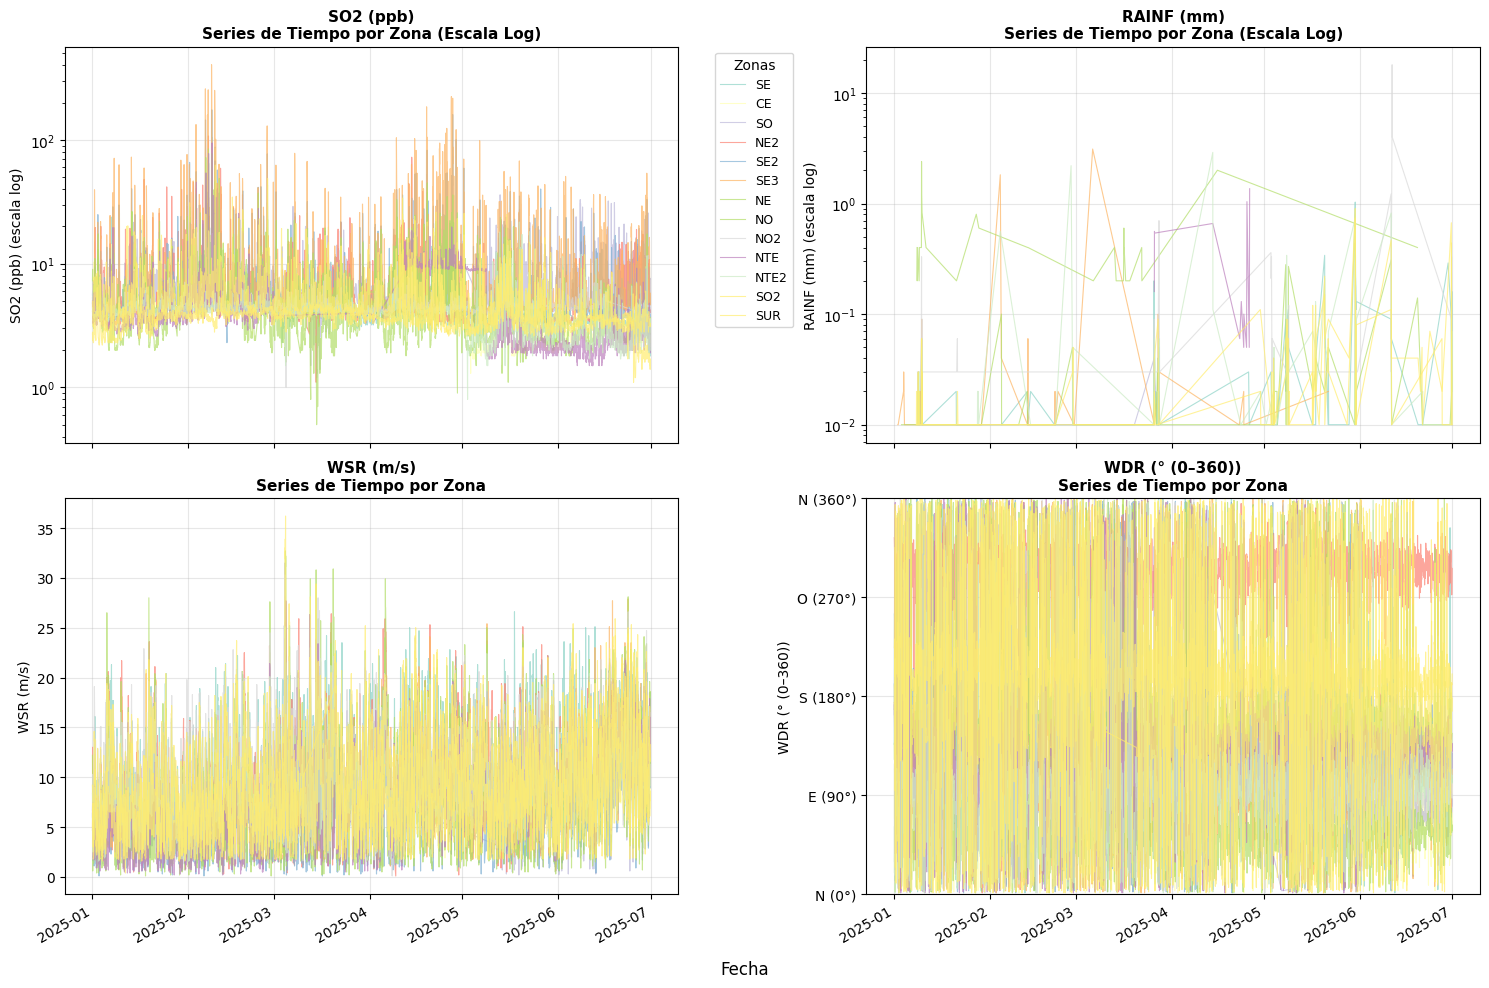


                     RESUMEN DE SERIES TEMPORALES POR ZONA                      

📈 Variable: SO2 ppb
------------------------------------------------------------
Zona  Puntos          Rango Temporal  Media  Mediana  Min   Max
  SE    4254 2025-01-01 a 2025-06-30  4.709      4.1  1.8  87.5
  CE    4263 2025-01-01 a 2025-06-30  5.180      4.8  1.3  85.8
  SO    4023 2025-01-01 a 2025-06-30  7.065      6.0  1.2  46.1
 NE2    4240 2025-01-01 a 2025-06-30  5.737      4.3  1.1 107.5
 SE2    4250 2025-01-01 a 2025-06-30  7.209      5.1  2.3 174.9
 SE3    4329 2025-01-01 a 2025-06-30  9.654      5.0  3.5 404.7
  NE    3562 2025-01-01 a 2025-06-30  5.763      5.0  0.9  84.5
  NO    4094 2025-01-01 a 2025-06-30  4.954      3.7  0.5  64.6
 NO2    4076 2025-01-01 a 2025-06-30  4.737      4.5  1.0  22.7
 NTE    3322 2025-01-01 a 2025-06-30  5.078      3.6  1.5  94.5
NTE2    4294 2025-01-01 a 2025-06-30  4.031      4.1  0.8  21.7
 SO2    4330 2025-01-01 a 2025-06-30  5.332      4.4  2.6  62.5
 SUR

In [26]:
# Función para crear series de tiempo por zona
def plot_timeseries_by_zone(dfs_dict, variables, figsize=(15, 10), layout='2x2'):
    """
    Crea gráficas de series de tiempo donde cada zona tiene un color diferente
    
    Parameters:
    - dfs_dict: diccionario con {zona: dataframe}
    - variables: lista de variables a graficar
    - figsize: tamaño de la figura
    - layout: '1x4' para una fila, '2x2' para dos filas, 'auto' para automático
    """
    
    # Variables que se benefician de escala logarítmica en el eje Y
    LOG_SCALE_VARS = ['SO2', 'RAINF']
    
    # Filtrar variables que existen en los datos
    available_vars = []
    for var in variables:
        if any(var in df.columns for df in dfs_dict.values()):
            available_vars.append(var)
    
    if not available_vars:
        print("No se encontraron variables válidas en los datos")
        return
    
    n_vars = len(available_vars)
    
    # Determinar layout de subplots
    if layout == '1x4' or (layout == 'auto' and n_vars <= 4):
        nrows, ncols = 1, n_vars
        figsize = (4*n_vars, 6)
    elif layout == '2x2' or (layout == 'auto' and n_vars == 4):
        nrows, ncols = 2, 2
        figsize = (15, 10)
    else:
        # Layout automático para otros casos
        ncols = min(3, n_vars)
        nrows = math.ceil(n_vars / ncols)
        figsize = (5*ncols, 4*nrows)
    
    # Crear figura con subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True)
    
    # Asegurar que axes sea un array 2D
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    
    # Aplanar para iterar fácilmente
    axes_flat = axes.flatten()
    
    # Colores para cada zona (usando la misma paleta que los histogramas)
    colors = plt.cm.Set3(np.linspace(0, 1, len(dfs_dict)))
    zone_colors = dict(zip(dfs_dict.keys(), colors))
    
    for i, var in enumerate(available_vars):
        ax = axes_flat[i]
        
        # Determinar si usar escala logarítmica
        use_log_scale = var in LOG_SCALE_VARS
        
        # Plotear cada zona
        zone_data_exists = False
        for zone, df in dfs_dict.items():
            if var in df.columns:
                # Convertir a numérico y preparar datos
                numeric_data = pd.to_numeric(df[var], errors='coerce')
                
                # Crear índice datetime si no existe
                if not isinstance(df.index, pd.DatetimeIndex):
                    # Buscar columna de fecha
                    date_cols = ['date', 'Date', 'datetime', 'Datetime', 'timestamp']
                    date_col = None
                    for col in date_cols:
                        if col in df.columns:
                            date_col = col
                            break
                    
                    if date_col:
                        # Parsear fecha
                        dates = pd.to_datetime(df[date_col], errors='coerce', dayfirst=False)
                        if not dates.isna().all():
                            # Crear serie temporal
                            ts_data = pd.Series(numeric_data.values, index=dates, name=var)
                            ts_data = ts_data.dropna().sort_index()
                        else:
                            continue
                    else:
                        continue
                else:
                    # Ya tiene índice datetime
                    ts_data = numeric_data.dropna().sort_index()
                
                if len(ts_data) > 0:
                    zone_data_exists = True
                    
                    if use_log_scale:
                        # Para escala log, filtrar valores positivos
                        positive_data = ts_data[ts_data > 0]
                        if len(positive_data) > 0:
                            ax.plot(positive_data.index, positive_data.values, 
                                   color=zone_colors[zone], alpha=0.7, linewidth=0.8, 
                                   label=zone)
                    else:
                        # Escala lineal normal
                        ax.plot(ts_data.index, ts_data.values, 
                               color=zone_colors[zone], alpha=0.7, linewidth=0.8, 
                               label=zone)
        
        if zone_data_exists:
            # Configurar la gráfica
            unit = UNITS.get(var, "")
            
            if use_log_scale:
                ax.set_yscale('log')
                title = f'{var} {f"({unit})" if unit else ""}\nSeries de Tiempo por Zona (Escala Log)'
                ylabel = f'{var} {f"({unit})" if unit else ""} (escala log)'
            else:
                title = f'{var} {f"({unit})" if unit else ""}\nSeries de Tiempo por Zona'
                ylabel = f'{var} {f"({unit})" if unit else ""}'
            
            ax.set_title(title, fontsize=11, fontweight='bold')
            ax.set_ylabel(ylabel)
            ax.grid(True, alpha=0.3)
            
            # Leyenda solo en la primera gráfica
            if i == 0:
                ax.legend(title='Zonas', bbox_to_anchor=(1.05, 1), loc='upper left', 
                         fontsize=9, ncol=1)
            
            # Tratamiento especial para WDR (dirección del viento)
            if var == 'WDR':
                ax.set_ylim(0, 360)
                ax.set_yticks([0, 90, 180, 270, 360])
                ax.set_yticklabels(['N (0°)', 'E (90°)', 'S (180°)', 'O (270°)', 'N (360°)'])
        else:
            ax.text(0.5, 0.5, f'Sin datos\nválidos para\n{var}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{var} (Sin datos)', fontsize=11)
    
    # Ocultar subplots vacíos
    for j in range(i+1, len(axes_flat)):
        axes_flat[j].axis('off')
    
    # Configurar fechas en el eje X
    fig.autofmt_xdate()
    
    # Añadir etiqueta común para el eje X
    fig.text(0.5, 0.02, 'Fecha', ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # Mostrar resumen de datos por zona
    print("\n" + "="*80)
    print(f"{'RESUMEN DE SERIES TEMPORALES POR ZONA':^80}")
    print("="*80)
    
    for var in available_vars:
        print(f"\n📈 Variable: {var} {UNITS.get(var, '')}")
        print("-" * 60)
        
        summary_data = []
        for zone, df in dfs_dict.items():
            if var in df.columns:
                numeric_data = pd.to_numeric(df[var], errors='coerce')
                clean_data = numeric_data.dropna()
                
                if len(clean_data) > 0:
                    # Obtener fechas para rangos temporales
                    if not isinstance(df.index, pd.DatetimeIndex):
                        date_cols = ['date', 'Date', 'datetime', 'Datetime', 'timestamp']
                        date_col = None
                        for col in date_cols:
                            if col in df.columns:
                                date_col = col
                                break
                        
                        if date_col:
                            dates = pd.to_datetime(df[date_col], errors='coerce')
                            date_range = f"{dates.min().strftime('%Y-%m-%d')} a {dates.max().strftime('%Y-%m-%d')}"
                        else:
                            date_range = "N/A"
                    else:
                        date_range = f"{df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}"
                    
                    summary_data.append({
                        'Zona': zone,
                        'Puntos': len(clean_data),
                        'Rango Temporal': date_range,
                        'Media': clean_data.mean(),
                        'Mediana': clean_data.median(),
                        'Min': clean_data.min(),
                        'Max': clean_data.max()
                    })
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            print(summary_df.round(3).to_string(index=False))

# Ejecutar la visualización de series temporales
print("📈 Creando series de tiempo por zona en formato 2x2...")
print("🔬 SO2 y RAINF utilizarán escala logarítmica en el eje Y")
print("🌈 Cada zona tendrá un color diferente para facilitar la comparación")
plot_timeseries_by_zone(dfs, CANDIDATES, figsize=(15, 10), layout='2x2')

# Funciones para Imputar Datos

SE USÓ INTERPOLACIÓN LINEAL

In [115]:
 ## Función para imputar si tenemos 7 días o menos sin datos

def impute_hourly_simple(
    df_full,
    numeric_cols=None,
    max_gap=7,                 # máximo tamaño de racha de NaNs a interpolar
):
    """
    Interpola huecos cortos con método temporal y deja en NaN los huecos largos.
    Devuelve:
      df_imp: DataFrame imputado
      mask_imputed: DataFrame booleano (True donde se imputó)
    """
    out = df_full.copy()
    if numeric_cols is None:
        numeric_cols = out.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [c for c in numeric_cols if c not in ("was_missing_timestamp", "has_missing_values")]

    # Asegura índice datetime
    if not isinstance(out.index, pd.DatetimeIndex):
        raise ValueError("El DataFrame debe estar indexado por DatetimeIndex para interpolar con method='time'.")

    before = out[numeric_cols].isna()

    # 1) Interpolación temporal limitada a rachas cortas
    out[numeric_cols] = out[numeric_cols].interpolate(
        method="time",
        limit=max_gap,
        limit_area="inside"   # no rellena bordes abiertos
    )

    after = out[numeric_cols].notna() & before  # posiciones que pasaron de NaN a valor

    # Máscara booleana por columna
    mask_imputed = after.reindex_like(out[numeric_cols]).fillna(False)

    return out, mask_imputed

In [118]:
df_imputed_lin, mask = impute_hourly_simple(
    grid_df, # SE DEBE USAR EL DF CON EL PARSEO DE FECHAS EN LA FUNCIÓN DE GRID
    numeric_cols=None,  # o lista explícita de columnas
    max_gap=7
)

**Función para imputar datos para más de 7 días de datos faltantes**

In [119]:
import pandas as pd
import numpy as np

def impute_seasonal(
    df: pd.DataFrame,
    cols: list[str],
    mode: str = "additive",          # 'additive' | 'multiplicative'
    cov_threshold: float = 0.75,     # cobertura mínima del bloque (año anterior)
    trend_window: str = "30D",
    min_periods_trend: int = 24,
    epsilon: float = 1e-8
):
    """
    Imputa bloques de NaN usando SOLO la misma variable en t-1 año, si la cobertura del año anterior
    para el bloque es >= cov_threshold. Ajusta por tendencia usando rolling temporal.

    Parámetros
    ----------
    df : DataFrame con DatetimeIndex (ya parseado y ordenado)
    cols : lista de columnas a imputar (numéricas)
    mode : 'additive' o 'multiplicative' (ajuste por tendencia)
    cov_threshold : umbral de cobertura del año anterior para imputar un bloque (0..1)
    trend_window : ventana temporal para la tendencia (p.ej. '30D')
    min_periods_trend : mínimos puntos no-NaN en la ventana para calcular tendencia
    epsilon : protector para división en modo multiplicativo

    Devuelve
    --------
    df_out : DataFrame con imputación aplicada
    mask_imputed : DataFrame booleano (True donde se imputó)
    audit : DataFrame con auditoría por bloque y columna
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df debe estar indexado por DatetimeIndex.")
    if df.index.size == 0:
        raise ValueError("df está vacío o sin índice válido.")
    if mode not in ("additive", "multiplicative"):
        raise ValueError("mode debe ser 'additive' o 'multiplicative'.")

    # Copia trabajo
    out = df.copy()
    # Asegura tipo numérico de columnas objetivo
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    # Tendencia por columna (rolling temporal + interpolación temporal)
    trend = (
        out[cols]
        .rolling(trend_window, min_periods=min_periods_trend)
        .mean()
        .interpolate(method="time", limit_area=None)
    )

    # Máscara de imputación
    mask_imputed = pd.DataFrame(False, index=out.index, columns=out.columns)

    # Utilidad: encontrar bloques contiguos de NaN en una Serie booleana
    def _nan_blocks(na_bool_index: pd.Index, na_mask: pd.Series) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
        """Devuelve lista de (start_ts, end_ts) para rachas contiguas de True en na_mask."""
        idx = na_bool_index
        v = na_mask.values.astype(bool)
        blocks = []
        start = None
        for i, flag in enumerate(v):
            if flag and start is None:
                start = idx[i]
            elif (not flag) and (start is not None):
                end = idx[i-1]
                blocks.append((start, end))
                start = None
        if start is not None:
            blocks.append((start, idx[-1]))
        return blocks

    # Auditoría
    audit_rows = []
    one_year = pd.DateOffset(years=1)

    for c in cols:
        if c not in out.columns:
            continue

        s = out[c]
        na_mask = s.isna()
        if not na_mask.any():
            continue

        # Encuentra bloques contiguos de NaN (por índice completo, no sólo por días)
        blocks = _nan_blocks(out.index, na_mask)

        for (b_start, b_end) in blocks:
            # Conjunto de timestamps del bloque
            S = out.index[(out.index >= b_start) & (out.index <= b_end)]
            if len(S) == 0:
                continue

            # Timestamps de referencia en el año anterior
            S_prev = S - one_year

            # Cobertura del año anterior para el bloque
            prev_vals = s.reindex(S_prev)
            coverage = float(prev_vals.notna().sum()) / float(len(S))

            # Auditoría básica del bloque antes de decidir
            audit_info = {
                "column": c,
                "block_start": b_start,
                "block_end": b_end,
                "block_len": len(S),
                "coverage_prev_year": coverage,
                "imputed": 0,
                "mode": mode
            }

            if coverage < cov_threshold:
                # No se imputa este bloque con esta política
                audit_rows.append(audit_info)
                continue

            # Imputación bloque (sólo celdas con base en t-1 año)
            imputed_count = 0
            for t in S:
                if pd.notna(out.at[t, c]):
                    continue  # ya se llenó por otra razón (raro), o no es NaN

                t_prev = t - one_year
                # Si para este timestamp puntual no hay base del año pasado, se deja NaN
                if t_prev not in out.index:
                    continue
                v_prev = out.at[t_prev, c]
                if pd.isna(v_prev):
                    continue

                T_t      = trend.at[t, c]      if t in trend.index else np.nan
                T_prev_t = trend.at[t_prev, c] if t_prev in trend.index else np.nan

                if mode == "additive":
                    if pd.notna(T_t) and pd.notna(T_prev_t):
                        y_hat = v_prev + (T_t - T_prev_t)
                    else:
                        y_hat = v_prev  # sin tendencia disponible: copia directa
                else:  # multiplicative
                    denom = T_prev_t if (pd.notna(T_prev_t) and abs(T_prev_t) > epsilon) else None
                    if pd.notna(T_t) and denom is not None:
                        y_hat = v_prev * (T_t / denom)
                    else:
                        y_hat = v_prev  # fallback seguro

                out.at[t, c] = y_hat
                mask_imputed.at[t, c] = True
                imputed_count += 1

            audit_info["imputed"] = imputed_count
            audit_rows.append(audit_info)

    audit = pd.DataFrame(audit_rows, columns=[
        "column", "block_start", "block_end", "block_len",
        "coverage_prev_year", "imputed", "mode"
    ])

    return out, mask_imputed, audit


In [120]:
df_yearimp, mask_yearimp, audit = impute_seasonal(
    df_imputed_lin,
    cols=vars_a_graficar,
    mode="additive",          # o "multiplicative"
    cov_threshold=0.75,
    trend_window="30D",
    min_periods_trend=24
)

In [121]:
# CANTIDAD DE NAS POR AÑO POR VARIABLE
cols = [c for c in vars_a_graficar]

na_year_var = df_yearimp[cols].isna().groupby(df_yearimp.index.year).sum()
na_year_var.index.name = "year"
na_year_var

,SO2,RAINF,WSR,WDR
year,,,,
2020,250,88,88,7193
2021,63,0,0,1932
2022,0,0,0,0
2023,0,0,0,0
2024,0,0,0,0
2025,0,0,0,0


In [122]:
#PORCENTAJES 
rows_per_year = df_yearimp.groupby(df_yearimp.index.year).size()  # filas por año
na_pct_year_var = na_year_var.div(rows_per_year, axis=0).multiply(100).round(2)
na_pct_year_var

,SO2,RAINF,WSR,WDR
year,,,,
2020,2.85,1.0,1.0,81.89
2021,0.72,0.0,0.0,22.05
2022,0.00,0.0,0.0,0.00
2023,0.00,0.0,0.0,0.00
2024,0.00,0.0,0.0,0.00
2025,0.00,0.0,0.0,0.00


# comparación de na antes y después de la imputación simple

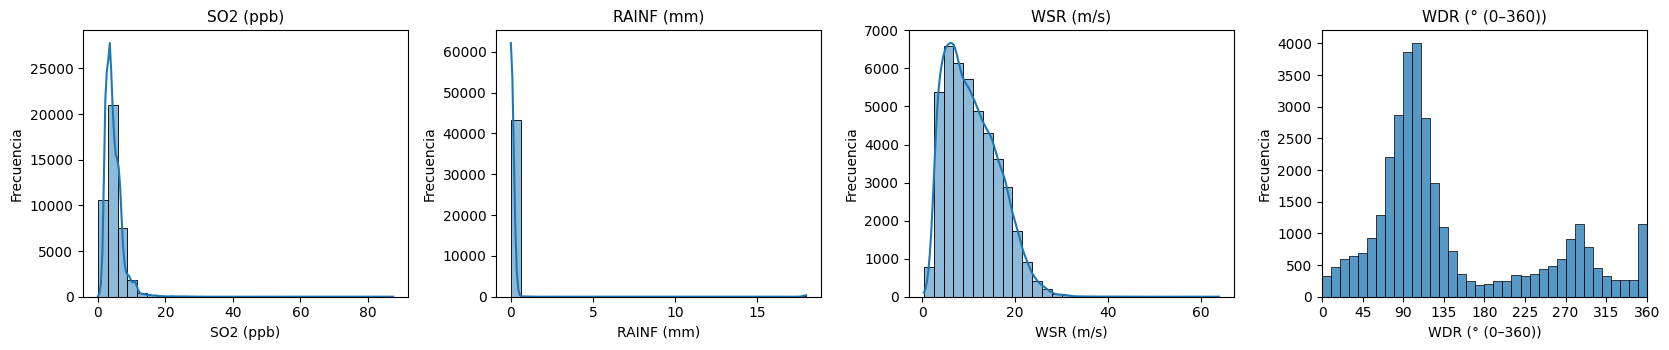

In [123]:
# histogramas de datos SIN IMPUTAR
plot_histograms(grid_df, cols=vars_a_graficar, bins=30, kde=True, max_cols=4)

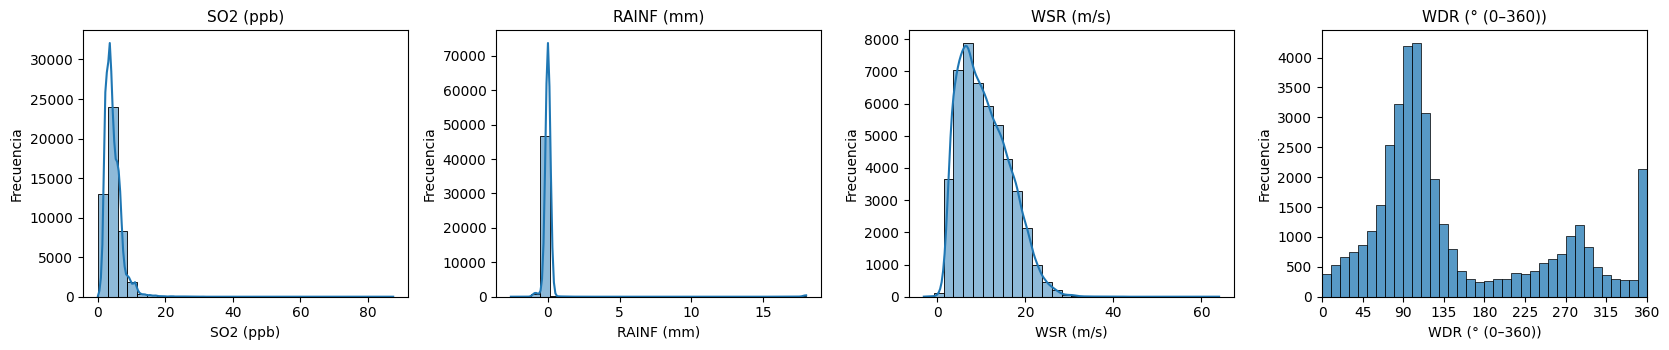

In [124]:
# histogramas de datos imputados todos
plot_histograms(df_yearimp, cols=vars_a_graficar, bins=30, kde=True, max_cols=4)

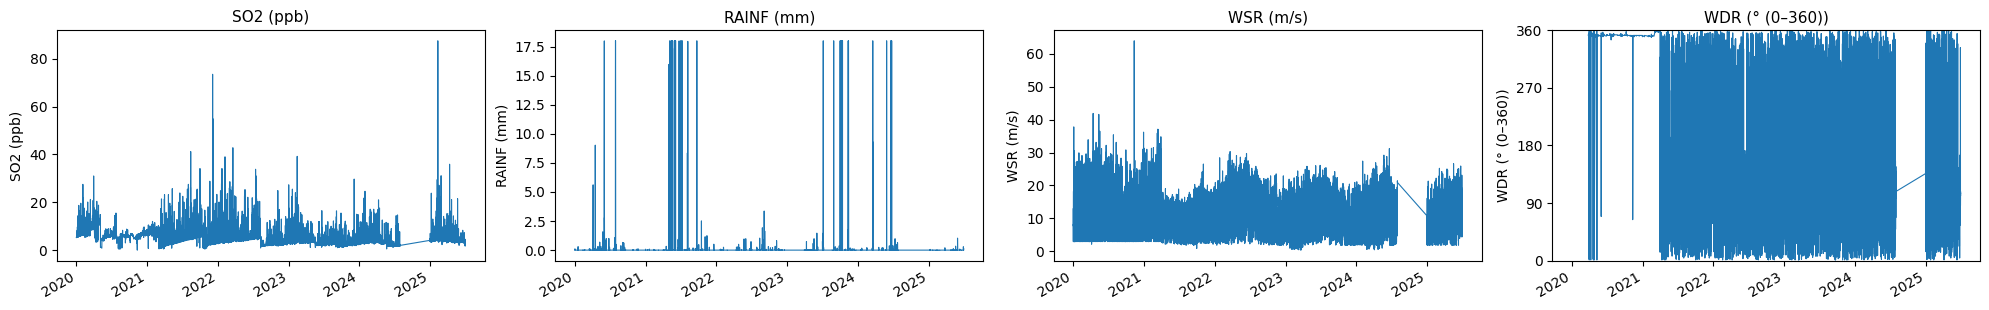

In [125]:
plot_timeseries(grid_df, cols=CANDIDATES)

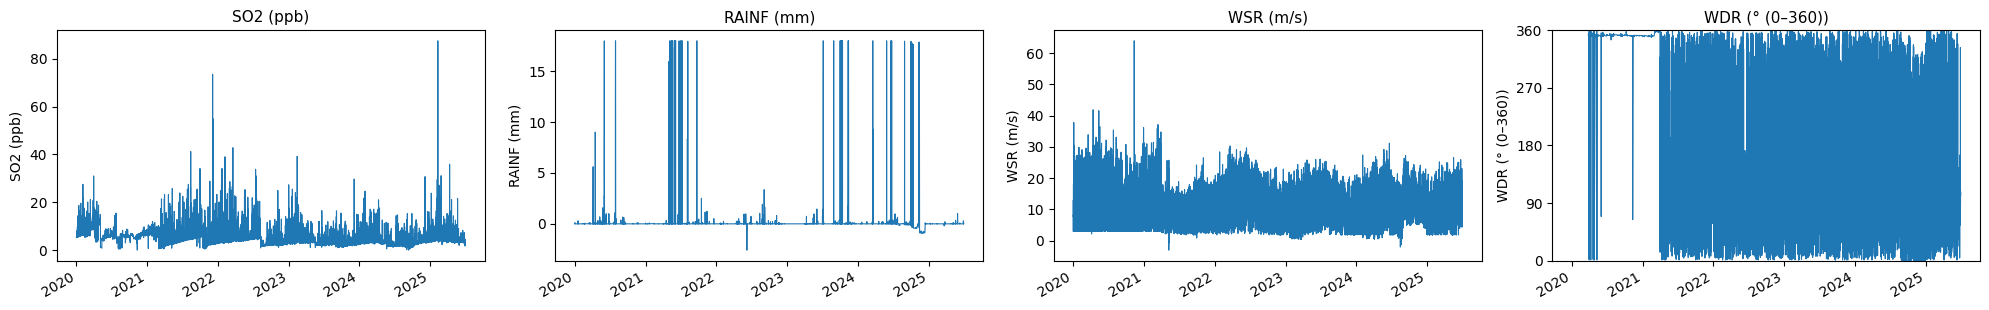

In [126]:
plot_timeseries(df_yearimp, cols=CANDIDATES)

## Escalar Datos

In [127]:
# no se le aplicará robust scales a WDR porque no son coordenadas
from sklearn.preprocessing import RobustScaler
def robust_scaler(df, exclude_cols=("WDR",)):
    """
    Devuelve:
        - df_scaled: DataFrame con columnas escaladas
        - scaler: objeto RobustScaler entrenado (útil para transformar nuevos datos)
    """
    out = df.copy()

    # columnas numéricas (float/int) que no están excluidas
    num_cols = out.select_dtypes(include=[np.number]).columns
    cols_to_scale = [c for c in num_cols if c not in exclude_cols]

    scaler = RobustScaler()
    out[cols_to_scale] = scaler.fit_transform(out[cols_to_scale])

    return out, scaler

In [128]:
df_scaled, scaler = robust_scaler(df_yearimp, exclude_cols=["WDR"])

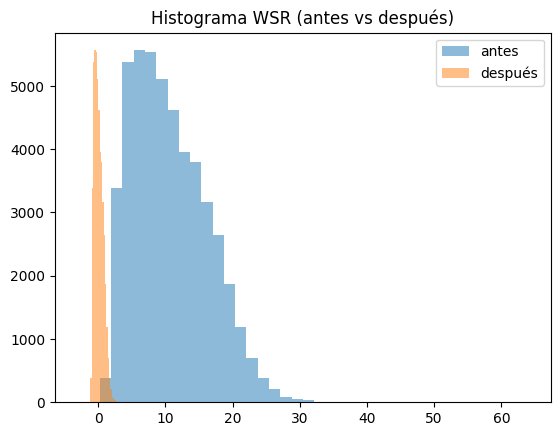

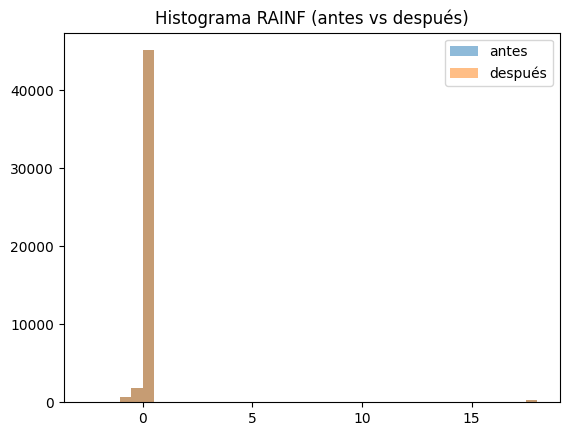

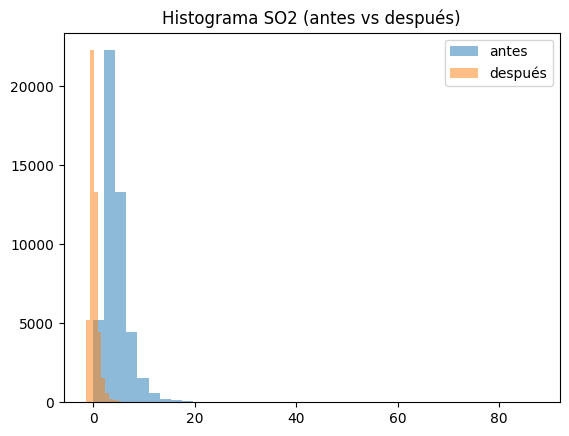

In [ ]:
# histogramas de datos imputados y escalados
vars_a_graficar = ["WSR", "RAINF", "SO2"] 

for col in vars_a_graficar:
    before = pd.to_numeric(df_yearimp[col], errors="coerce").dropna()
    after  = df_scaled[col].dropna()

    plt.figure()
    plt.hist(before, bins=40, alpha=0.5, label="antes")
    plt.hist(after,  bins=40, alpha=0.5, label="después")
    plt.legend()
    plt.title(f"Histograma {col} (antes vs después)")
    plt.show()


## Base de datos Final 
Imputada y escalada, no se utilizarán los datos del 2020 porque por la forma en la que se hace la imputación no se pueden eliminar datos na

In [137]:
df_final = df_scaled.loc[~(df_scaled.index.year == 2020)]
df_final = df_final[['SO2', 'RAINF', 'WSR', 'WDR']]
df_final

,SO2,RAINF,WSR,WDR
date,,,,
2021-01-01 00:00:00,0.793103,0.00,-0.392857,351.0
2021-01-01 01:00:00,0.862069,0.00,0.511905,351.0
2021-01-01 02:00:00,0.793103,0.00,0.190476,351.0
2021-01-01 03:00:00,0.758621,0.00,-0.392857,351.0
2021-01-01 04:00:00,0.793103,0.00,-0.285714,351.0
...,...,...,...,...
2025-06-30 19:00:00,-0.689655,0.01,0.654762,106.0
2025-06-30 20:00:00,-0.655172,0.00,0.845238,101.0
2025-06-30 21:00:00,-0.724138,0.16,0.714286,108.0
